## Import libraries

In [1]:
import json
import requests
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

## Open the csv from the batch download and convert to JSON
### Also open a previous stats file if you've already collected that

In [2]:
#change the name here to your csv file
batchdf = pd.read_csv('batch-download-metadata.csv',encoding='utf8') 
result = batchdf.to_json(orient="records")
full_articles = json.loads(result)

In [3]:
#Open an existing stats file that matches you batch metadata file (Otherwise, continue to next step)
dfstats = pd.read_csv('article-stats.csv',encoding='utf8')

## Collect stats (unless you've already done this)

In [42]:
#Create a list of all the article ids
article_ids = [item['id'] for item in full_articles]

In [15]:

#Create csv file
metadata=open('article-stats.csv', 'w', newline='')
#Write header row to csv
csv.writer(metadata).writerow(['article_id','views','downloads'])            

            
for l in article_ids:
    s=requests.get('https://stats.figshare.com/total/views/article/'+ str(l))
    r=json.loads(s.text)
    t=requests.get('https://stats.figshare.com/total/downloads/article/'+ str(l))
    q=json.loads(t.text)
    
    #write the values to the csv file. Dates in json files are seconds from jan 1 1970 so datetime.datetime.fromtimestamp converts
    csv.writer(metadata).writerow([
        l,
        r.get('totals'), #For any of these .get(), adding ",'N/A'" will fill the null cells with 'N/A'. However, metadata assessment counts non nulls
        q.get('totals')]) 
    
    
metadata.close() #Close the output file, release all locks

#Open up the same file as a dataframe. Encode cp1252 avoids a utf8 error.
dfstats = pd.read_csv('article-stats.csv',encoding='utf8')

print('The resulting dataframe has',len(dfstats),'rows')

The resulting dataframe has 171 rows


## Summarize and Examine

From here on out, you need the batch metadata csv/dataframe, the json version of that csv, and the stats csv/dataframe.
Here are the dataframes:

- batchdf (all metadata but the funding and categories are formatted still)
- full_articles (JSON version of batchdf to be used to extract funding and category information)
- dfstats (Views and downloads for each record, this will be merged with full_articles)


## Merge metadata with stats

In [4]:
#Merge the dataframes
df_final = batchdf.merge(dfstats, how='inner', on='article_id')
len(df_final)

171

## Collect funder name
Funder name is not in the metadata download.For records with a link to a grant record in Dimensions, the funder name is a separate field.

In [21]:
#create list of article ids and then visit each one to get funder names
article_ids = df_final['article_id'].tolist()

funder_list = []

for l in article_ids:
    s=requests.get('https://api.figshare.com/v2/articles/'+ str(l))
    r=json.loads(s.text)
    for x in r['funding_list']:
        f = {'article_id': l, "funder": x['funder_name']}
        funder_list.append(f)

funderdf = pd.json_normalize(funder_list) #create a dataframe

print(len(funderdf),'funder names collected')


267 funder names collected


In [22]:
#Save File
with open('IA-funders.json', "w") as write_file:
    json.dump(funder_list, write_file)

In [19]:
#Open an existing funder file
f = open('IA-funders.json')
funder_list = json.load(f)

funderdf = pd.json_normalize(funder_list) #create a dataframe

print(len(funderdf),'funder names in list')

267 funder names in list


In [11]:
funder_list[10]

{'article_id': 16934038, 'funder': 'Directorate for Geosciences'}

## Extract values from JSON formatted fields - Grants and Categories

In [12]:
#This uses the funding information that comes with the batch metadata
#Extract funding lists to a dataframe. The "JSON" is currently stored as a big list.

grants = []
for i in full_articles:
    info = {"itemid": i['article_id'], "funding_list": list(eval(i['funding']))} #eval converts the string to a list
    grants.append(info)

grantsdf = pd.json_normalize(
    grants, 
    record_path =['funding_list'], 
    meta=['itemid']
)


In [13]:
#Extract categories lists to a dataframe
categories = []
for i in full_articles:
    #license_list.append((i['license']['name'],i['doi']))
    info = {"itemid": i['article_id'], "category": list(eval(i['categories']))}
    categories.append(info)

categorydf = pd.json_normalize(
    categories, 
    record_path =['category'], 
    meta=['itemid']
)

categorydf = categorydf.rename(columns={categorydf.columns[0]: 'category'}) #renames the column just in case it isn't named properly

Now there are four dataframes: 

- df_final with all metadata and views/downloads
- categorydf with a list of categories 
- fundersdf with a list of funder names 
- grantsdf with grant names

In [14]:
#Look at licenses
df_final['license'].value_counts()

https://creativecommons.org/licenses/by/4.0/          156
https://creativecommons.org/publicdomain/zero/1.0/     13
https://opensource.org/licenses/MIT                     2
Name: license, dtype: int64

In [15]:
embargoed = df_final['is_embargoed'].sum()
meta_only = df_final['metadata_record_only'].sum()
linked_file = df_final['linked_file'].count()
print(embargoed,'embargoed record(s),',meta_only,'metadata-only record(s) and',linked_file,'linked file record(s).')

0 embargoed record(s), 3 metadata-only record(s) and 2 linked file record(s).


In [16]:
#Look at links to publications
linkbacks = df_final['resource_doi'].unique()
print(len(linkbacks),'records (',len(linkbacks)/len(df_final)*100,'percent) linked to a publication')

25 records ( 14.619883040935672 percent) linked to a publication


### Funder Name

In [20]:
#Look at funder list
funderdf['funder'].value_counts()

Directorate for Engineering                                     40
Directorate for Biological Sciences                             21
Directorate for Geosciences                                     10
National Institute of Food and Agriculture                       9
Directorate for Computer & Information Science & Engineering     3
United States Department of the Navy                             3
Directorate for Education & Human Resources                      3
National Institute of General Medical Sciences                   2
Directorate for Mathematical & Physical Sciences                 2
United States Department of the Army                             1
National Oceanic and Atmospheric Administration                  1
National Institute on Aging                                      1
National Institute of Justice                                    1
National Aeronautics and Space Administration                    1
National Institute of Allergy and Infectious Diseases         

In [21]:
#Create a dataframe of unique grants by item id and add views and downloads
funderuniques = funderdf.drop_duplicates()

#Merge the dataframes
funder_stats = funderuniques.merge(dfstats, how='inner')

#Count records Groupby funder_name if it existed would be ideal- to see views by funder not grant name.
funder_view_count = funder_stats.groupby('funder')['views'].sum().reset_index().sort_values(by='views', ascending=False)


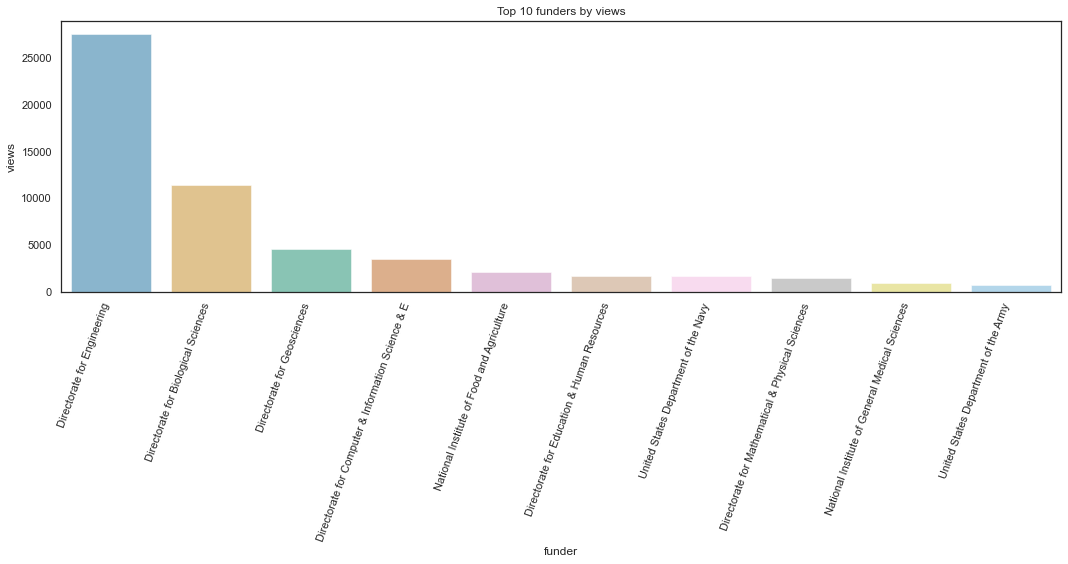

In [86]:
#Look at views by linked grant name
funder_view_count = funder_view_count.head(10) #select the top 10 grants by views
funder_view_count['funder'] = funder_view_count['funder'].str[:50] #Truncate the titles so the graph is not insane
plt.figure(figsize=(15,8))
sns.set_theme(style="white")
sns.barplot(x='funder', y="views",
            alpha=.5, palette="colorblind",
            data=funder_view_count, ci=None).set(title='Top 10 funders by views')
plt.xticks(rotation=70, ha="right")
plt.tight_layout()

### Standardize funder mentions by number of items

In [44]:
#Create a dataframe of unique grants by item id and add views and downloads
pd.options.mode.chained_assignment = None #turns off the SettingWithCopyWarning

funderuniques = funderdf.drop_duplicates()
funderuniques['fundercount'] = funderuniques.groupby('funder')['funder'].transform('count')

#Merge the dataframes
funder_stats = funderuniques.merge(dfstats, how='inner')

#sum the views by funder name and include the funder name count
funder_viewstd_count = funder_stats.groupby(['funder','fundercount'])['views'].sum().reset_index().sort_values(by='views', ascending=False)

#Divide the views by count of items for each funder name
funder_viewstd_count['views-std'] = funder_viewstd_count['views']/funder_viewstd_count['fundercount']

pd.options.mode.chained_assignment = 'warn' #Turns the warning back on.


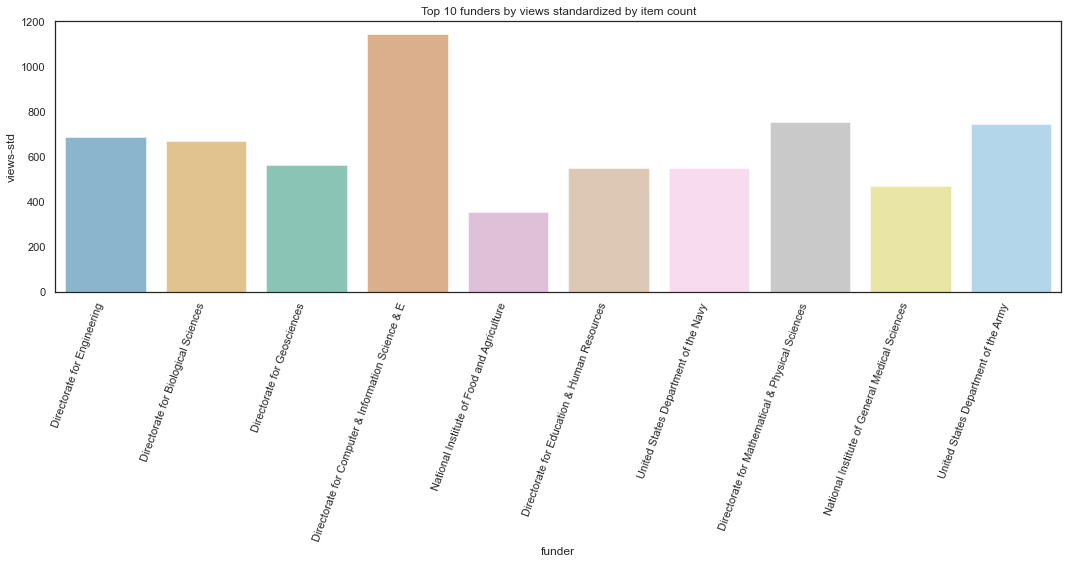

In [85]:
#Look at views by linked grant name
funder_viewstd_count = funder_viewstd_count.head(10) #select the top 10 grants by views
funder_viewstd_count['funder'] = funder_viewstd_count['funder'].str[:50] #Truncate the titles so the graph is not insane
plt.figure(figsize=(15,8))
sns.set_theme(style="white")
sns.barplot(x='funder', y="views-std",
            alpha=.5, palette="colorblind",
            data=funder_viewstd_count, ci=None).set(title='Top 10 funders by views standardized by item count')
plt.xticks(rotation=70, ha="right")
plt.tight_layout()

### Grant Name

In [49]:
#Create a dataframe of unique grants by item id and add views and downloads
grantsuniques = grantsdf[['title','itemid']].copy()
grantsuniques = grantsuniques.drop_duplicates()

#Merge the dataframes
grant_stats = grantsuniques.merge(dfstats, how='inner', left_on=['itemid'], right_on=['article_id'])

#Count records Groupby funder_name if it existed would be ideal- to see views by funder not grant name.
grant_view_count = grant_stats.groupby('title')['views'].sum().reset_index().sort_values(by='views', ascending=False)


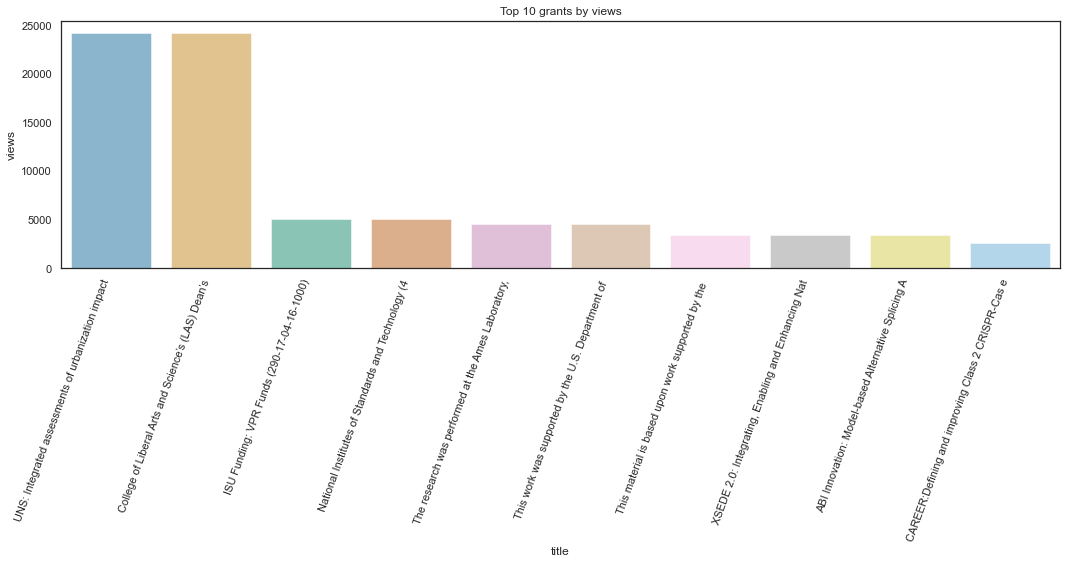

In [87]:
#Look at views by linked grant name
grant_view_count = grant_view_count.head(10) #select the top 10 grants by views
grant_view_count['title'] = grant_view_count['title'].str[:50] #Truncate the titles so the graph is not insane
plt.figure(figsize=(15,8))
sns.set_theme(style="white")
sns.barplot(x='title', y="views",
            alpha=.5, palette="colorblind",
            data=grant_view_count, ci=None).set(title='Top 10 grants by views')
plt.xticks(rotation=70, ha="right")
plt.tight_layout()

In [79]:
cat_count = categorydf[['title']]
cat_count = categorydf.title.value_counts().reset_index().rename(columns={'index': 'title', 'title': 'count'})

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Climatology'),
  Text(1, 0, 'Other environmental sciences not elsewhere classified'),
  Text(2, 0, 'Other earth sciences not elsewhere classified'),
  Text(3, 0, 'Statistics not elsewhere classified'),
  Text(4, 0, 'Forensic evaluation, inference and statistics'),
  Text(5, 0, 'Materials engineering not elsewhere classified'),
  Text(6, 0, 'Agronomy'),
  Text(7, 0, 'Conservation and biodiversity'),
  Text(8, 0, 'Genomics'),
  Text(9, 0, 'Applied statistics')])

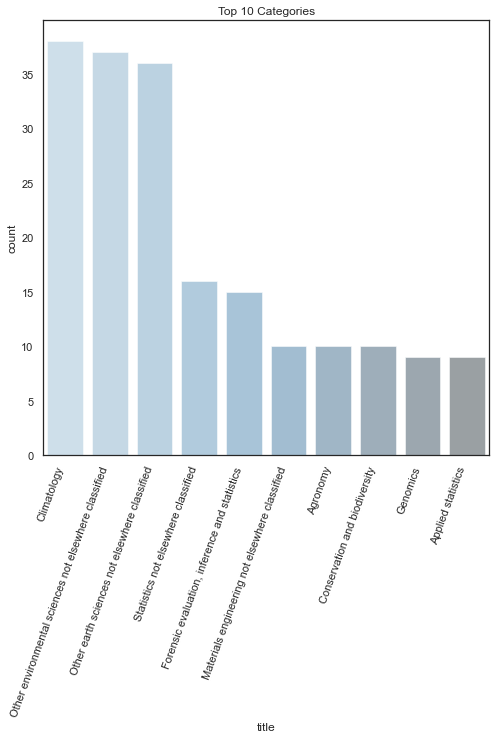

In [82]:
top_cats = cat_count.head(10)
plt.figure(figsize=(8,8))
sns.set_theme(style="white")
sns.barplot(x='title', y="count",
            alpha=.5, palette="Blues_d",
            data=top_cats, ci=None).set(title='Top 10 Categories')
plt.xticks(rotation=70, ha="right")


In [18]:
#Save the dataframes
save_file = df_final.to_csv("dfFinal.csv")
save_file = top_cats.to_csv("topCats.csv")
save_file = funder_view_count.to_csv("funderViews.csv")